# Implicit Regularization

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/notebooks/Lab-12.Implicit_regularization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this lab, we will study the *implicit bias* induced by *Gradient Descent* optimization in the simple case of *linear regression*, fitted on a toy dataset. In particular, we will show that GD-optimized weights converge to the **least norm** solution of the linear regression problem.

Then, we will study how different initializations and different optimizers affect the weights learned by a *Convolutional neural network*.


An analysis of implicit regularization (aka implicit bias) induced by *Stochastic Gradient Descent* in *full-width linear fully-connected* and *full-width linear convolutional* neural networks is provided in [this paper](https://arxiv.org/abs/1806.00468).



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import random

random.seed(546)
np.random.seed(987)

## Linear regression


Let's first create a function which generates data. You've already seen this in many previous labs.

In [3]:
def datagen(d, points, m, M, w, sigma):
    X = np.zeros((points,d))
    for i in range(points):
        X[i,:] = np.random.uniform(m, M, d)
    eps = np.random.normal(0, sigma, points)
    y = np.dot(X,w) + eps 
    return X, y

We can visualise the data created if $d=1$.

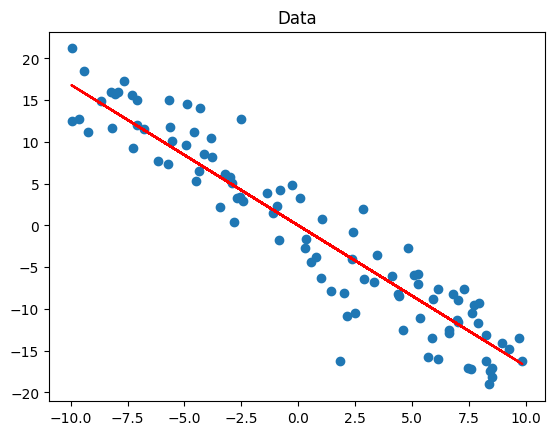

In [4]:
d = 1
w = np.random.normal(0, 1, d)
sigma = 3
points = 100
m = -10
M = 10

X, y = datagen(d, points, m, M, w, sigma)
fig, ax =plt.subplots()
ax.scatter(X,y)
ax.plot(X,np.dot(X,w), color = "red")
ax.set_title('Data')

fig.show()

Let's now create the data set that we will use, in a higher dimension.

In [5]:
d = 10
w = np.random.normal(0,1,d)
sigma = 3
points = 1000
m = -10
M = 10

X, y = datagen(d, points, m, M, w, sigma)

In the case of **linear regression**, fitted by means of *least squares*, we optimize the following loss function:
$$
L=\|y-Xw\|_{2}^{2}.
$$

If we choose the *GD* optimization algorithm, we perform weight updates proportional to the gradient of the loss function:
$$
\nabla_{w} L = -X^{T}(y-Xw)/N.
$$

Additionally, notice that the **least norm** solution of the *linear regression* problem is given by:
$$
w^{*}=(X^{T}X + \lambda I)^{-1}X^{T}y.
$$

##### 1. Compute the least norm solution of the linear regression problem.

In [6]:
def least_norm_reg(X, y, lam):
    mm = X.T @ X + lam * np.eye(X.shape[1])
    yy = X.T @ y
    return np.linalg.solve(mm,yy)

least_norm_reg(X,y,0.01)

array([-0.40968993, -0.19539189,  1.48370564,  0.83462127, -0.79678513,
        0.14990911,  0.74075845,  1.58646258,  0.70830193,  0.28207994])

##### 2. Perform GD optimization of the linear regression problem iteratively, storing the weights at each iteration.

In [7]:
# gradient of the MSE corresponding to the ordinary least squares solution for linear regression
def OLSGradient(X, y, w):
    n = X.shape[0]
    return -X.T @ (y - X @ w)/n

# gradient descent for linear regression with learning rate gamma
def GD(X, y, niter, gamma):
    d = X.shape[1]
    w = np.random.rand(d,1)/d
    y = y.reshape((-1,1))

    losses = np.zeros(niter)
    for i in range(niter):
        y_pred = np.dot(X,w)
        diff = y - y_pred
        losses[i] = np.linalg.norm(diff)
        w = w - gamma * OLSGradient(X,y,w)
    return losses 


##### 3. Plot the evolution of the weights during GD optimization, showing their relation with the least norm solution.

In [8]:
losses = GD(X, y, 1000, 0.001) 

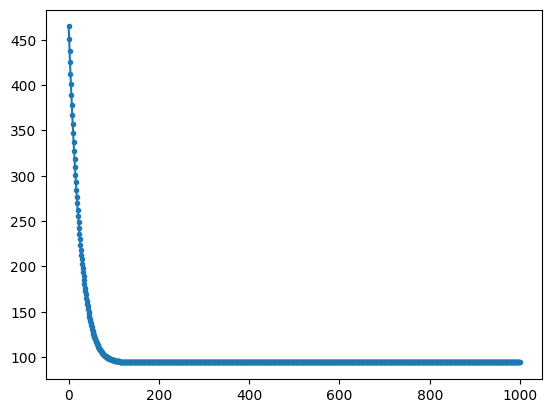

In [9]:
plt.plot(losses, ".-")

## Convolutional Neural Network

*Remember to enable GPU acceleration! `Runtime` > `Change runtime type` > `Hardware acceleration` > `GPU`*

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from time import time

torch.manual_seed(0)

### Loading the data set

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set consists of $60000$ $32x32$ colour images in $10$ classes, with $6000$ images per class. There are $50000$ training images and $10000$ test images. 


In [11]:
BATCH_SIZE = 32

# Convert data to PyTorch tensor form and normalise it
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## download and load training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


#### Visualising the data

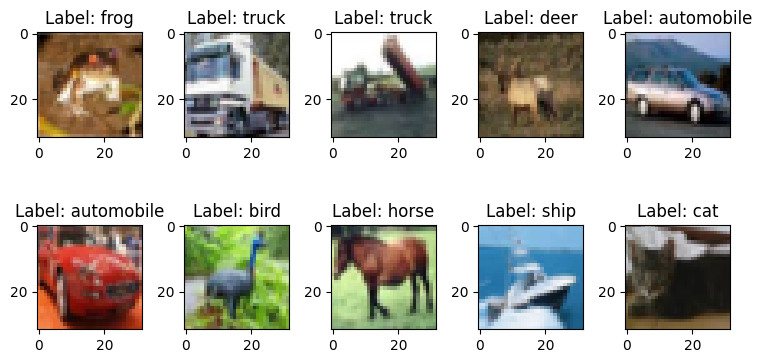

In [12]:
num_row = 2
num_col = 5

classes = trainset.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(classes[trainset.targets[i]]))
plt.tight_layout()
plt.show()

In [14]:
# printing data shapes 
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    print(labels)
    break

Single image dimensions: (32, 32, 3)
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])
tensor([0, 3, 2, 3, 6, 1, 4, 8, 5, 5, 4, 1, 5, 4, 5, 4, 8, 8, 3, 2, 9, 6, 4, 0,
        4, 8, 2, 3, 5, 5, 0, 1])


In [1]:
trainset.data[0]

NameError: name 'trainset' is not defined

### Defining the model

##### 4. Define a CNN with one convolutional layer and two linear layers (be careful of the dimensions!)

In [37]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=3)
        self.l1 = torch.nn.Linear(in_features = 16 * 30 * 30, out_features = 128)
        self.l2 = torch.nn.Linear(in_features = 128, out_features = 10)
    def forward(self,x):
        x = self.c1(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        #x = F.softmax(x, dim = 1)
        return x
        

#### Defining the auxiliary functions

In [38]:
# functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
    accs = []

    norms = []
    
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            
            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
        
            
        losses.append(train_running_loss / i)
        accs.append(train_acc/i)
        
        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}") 
    
    return losses, accs, norms

#### Training with different optimizers

An optimizer is an algorithm that adjusts the weights of a model in order to minimize its loss function. There are many different optimizers available in deep learning, each with its own strengths and weaknesses, and its choice depends on the specific problem and model being trained, and is often a matter of trial and error.   
Different optimizers can affect the weights of a model in different ways because they use different algorithms to update the weights during training.

##### 5. Train the model with two different optimizers and see in a plot how the weights differ ([hint](https://pytorch.org/docs/stable/optim.html)).

In [39]:
torch.cuda.is_available()

True

In [42]:
model_adam = CNN()
optimizer = torch.optim.Adam(model_adam.parameters(), lr = 0.001) 

losses, accs, norms = train_model(model_adam, 10, trainloader, torch.nn.CrossEntropyLoss(), optimizer)

Epoch: 1 | Loss: 1.4865 | Train Accuracy: 46.5489 | Time: 14.72
Epoch: 2 | Loss: 1.1909 | Train Accuracy: 57.9205 | Time: 14.78
Epoch: 3 | Loss: 1.0318 | Train Accuracy: 63.5023 | Time: 14.47
Epoch: 4 | Loss: 0.9062 | Train Accuracy: 67.9477 | Time: 14.70
Epoch: 5 | Loss: 0.7865 | Train Accuracy: 72.4592 | Time: 14.67
Epoch: 6 | Loss: 0.6825 | Train Accuracy: 75.8143 | Time: 14.74
Epoch: 7 | Loss: 0.5860 | Train Accuracy: 79.4434 | Time: 14.66
Epoch: 8 | Loss: 0.5000 | Train Accuracy: 82.6244 | Time: 14.73
Epoch: 9 | Loss: 0.4192 | Train Accuracy: 85.3073 | Time: 14.68
Epoch: 10 | Loss: 0.3429 | Train Accuracy: 88.2342 | Time: 14.66


In [43]:
model_sgd = CNN()
optimizer = torch.optim.SGD(model_sgd.parameters(), lr = 0.001) 

losses, accs, norms = train_model(model_sgd, 10, trainloader, torch.nn.CrossEntropyLoss(), optimizer)

Epoch: 1 | Loss: 2.1282 | Train Accuracy: 24.9380 | Time: 13.80
Epoch: 2 | Loss: 1.8980 | Train Accuracy: 33.9289 | Time: 14.00
Epoch: 3 | Loss: 1.7786 | Train Accuracy: 38.3583 | Time: 13.60
Epoch: 4 | Loss: 1.6969 | Train Accuracy: 41.0251 | Time: 13.81
Epoch: 5 | Loss: 1.6273 | Train Accuracy: 43.4419 | Time: 13.95
Epoch: 6 | Loss: 1.5691 | Train Accuracy: 45.4706 | Time: 13.70
Epoch: 7 | Loss: 1.5195 | Train Accuracy: 46.9130 | Time: 13.75
Epoch: 8 | Loss: 1.4768 | Train Accuracy: 48.3555 | Time: 13.96
Epoch: 9 | Loss: 1.4390 | Train Accuracy: 49.6039 | Time: 13.66
Epoch: 10 | Loss: 1.4047 | Train Accuracy: 50.7903 | Time: 13.88


#### Training with different initializations

By default, linear layers are initialised with a uniform distribution bounded by $\dfrac{1}{\sqrt{in features}}$, while conv2d layers by a uniform distribution bouded by $\dfrac{1}{\sqrt{(in features) \cdot k}}$ , where $k$ is the kernel size.

By changing the default kernel initialization, the weights of the model vary.

##### 6. Try to change the model weight initialization and see how they compare with the ones computed with the default one ([hint](https://pytorch.org/docs/stable/nn.init.html)).

In [ ]:
# YOUR CODE